In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
from tqdm import tqdm
import spatialdata as sd

import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys
sys.path.append('..')
from configuration import STConfig
from wrappers.sdata_initalizer import SDataInitalizer
from wrappers.sdata_customizer import SDataCustomizer
from utils.utils_colors import spatiotypes_color_map, cell_color_dict_coarse

### Loading Configuration

In [2]:
cfg = STConfig()
meta_df = pd.read_csv(cfg.pth_meta_csv)
samples = meta_df['sample_key'].tolist()
print(f'Number of samples {len(samples)}')
print(samples)

Number of samples 32
['10693_R2', '10693_R1', '16832_R1', '16832_R2', '16818_R2', '16818_R1', '16818_R3', '18552_R3', '18552_R1', '18552_R2', '18550_R1', '18550_R3', '18550_R2', '18606_R2', '18606_R3', '18606_R1', '18599_R3', '18599_R1', '18599_R2', '18286_R3', '18286_R2', '18286_R1', '18256_R3', '18256_R1', '18256_R2', '18612_R1', '18612_R4', '18612_R2', '18612_R3', '18669_R3', '18669_R2', '18669_R1']


### Reading spatiotypes csv file

In [3]:
celltype_col = 'obj.anno_5_w_megs_w_stromal'
spatiotype_col = 'ENVIRON'
sptDf = pd.read_csv(cfg.pth_spatiotypes_label, index_col='Unnamed: 0')
skey = 'sample_key'
sptDf[skey] = sptDf['cell_id'].str.split('_').str[-2:].map('_'.join)
sptDf.head(3)

/tmp/slurm-2157431/ipykernel_475531/1171532615.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sptDf = pd.read_csv(cfg.pth_spatiotypes_label, index_col='Unnamed: 0')


,region,slide,cell_id,area,cell_status,meg_phenotype,annotation,it_regions,mutation_status,run,...,obj.anno_5_w_megs,extra_new_cell_status,sR_cell_refined,obj.anno_1_w_megs_w_stromal,obj.anno_2_w_megs_w_stromal,obj.anno_3_w_megs_w_stromal,obj.anno_4_w_megs_w_stromal,obj.anno_5_w_megs_w_stromal,ENVIRON,sample_key
aaabbbkl-1_10693_R2,new_cell_boundaries,morphology_focus,aaabbbkl-1_10693_R2,11591.402473,original,non_meg,keep,14.0,JAK2,Run1,...,MNP,original,NaN,DC,DC,DC,MNP,MNP,MNP-2,10693_R2
aaabpmkp-1_10693_R2,new_cell_boundaries,morphology_focus,aaabpmkp-1_10693_R2,12974.009823,original,non_meg,keep,14.0,JAK2,Run1,...,Erythroid,original,NaN,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid-2,10693_R2
aaabpmmk-1_10693_R2,new_cell_boundaries,morphology_focus,aaabpmmk-1_10693_R2,1247.499138,original,non_meg,keep,14.0,JAK2,Run1,...,Myeloid,original,NaN,Myeloid,Myeloid,Myeloid,Myeloid,Myeloid,Myeloid-0,10693_R2


In [4]:
# To make notebook size managable we show only 3 random samples
N_samples = 3
samples = np.array(samples)
samples = list(samples[np.random.randint(0, len(samples), N_samples)])
if '16832_R1' not in samples:
    samples.append('16832_R1')

0it [00:00, ?it/s]

Visualizing Manual Annotation for sample 16832_R1


/tmp/slurm-2157431/ipykernel_475531/2613131933.py:34: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  cell_boundaries.plot(
/tmp/slurm-2157431/ipykernel_475531/2613131933.py:44: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  cell_boundaries.plot(


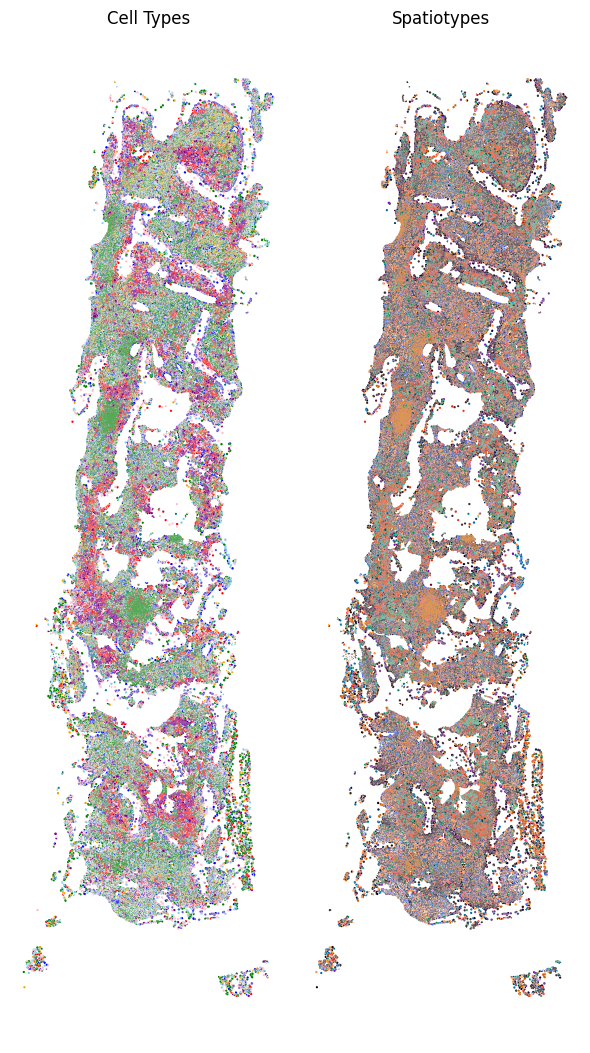

1it [01:09, 69.94s/it]


In [5]:
samples = ['16832_R1']
for idx, sample_id in tqdm(enumerate(samples)):
    print(f'Visualizing Manual Annotation for sample {sample_id}')
    customizer = SDataCustomizer(config=cfg, sample_key=sample_id)
    sdata_file_path = f'{cfg.pth_sdata}/{sample_id}_no_he.zarr'
    sdata_obj = sd.read_zarr(sdata_file_path)
    
    df = sptDf[sptDf[skey] == sample_id].loc[:, [celltype_col, spatiotype_col]]
    gdf = sdata_obj.shapes['new_cell_boundaries']
    cell_boundaries = gdf.merge(df, left_index=True, right_index = True).dropna()
    minx, miny, maxx, maxy = cell_boundaries.total_bounds
    width  = maxx - minx
    height = maxy - miny

    if width > height:
        # Tissue section oriented horizontally
        figsize = (18, 6)
    else:
        figsize = (6, 18) 

    df = sptDf[sptDf[skey] == sample_id].loc[:, [celltype_col, spatiotype_col]]
    gdf = sdata_obj.shapes['new_cell_boundaries']
    cell_boundaries = gdf.merge(df, left_index=True, right_index = True).dropna()
    cell_boundaries[celltype_col].replace({'Adipo-MSC':'Stromal', 'SMC':'Stromal'}, inplace=True)
    minx, miny, maxx, maxy = cell_boundaries.total_bounds
    width  = maxx - minx
    height = maxy - miny

    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes = axes.flatten()

    ax_0 = axes[0]
    cell_boundaries.plot(
        column = celltype_col, 
        color = cell_boundaries[celltype_col].map(cell_color_dict_coarse),
        ax=ax_0
    )

    ax_0.axis("off")
    ax_0.set_title('Cell Types')

    ax_1 = axes[1]
    cell_boundaries.plot(
        column = spatiotype_col, 
        color = cell_boundaries[spatiotype_col].map(spatiotypes_color_map),
        ax=ax_1
    )

    ax_1.axis("off")
    ax_1.set_title('Spatiotypes')
    plt.tight_layout()
    plt.show()